In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
import itertools
from scipy.optimize import linear_sum_assignment
from IPython.display import clear_output
import cma

## Makeshift neural network for experiments

In [5]:
class Linear():
    def __init__(self, nin, nout):
        self.mat = np.random.normal(0,1,(nin, nout))
        self.bias = np.zeros((1, nout))
    def forward(self, x):
        return np.dot(x, self.mat) + self.bias
    def get_params(self):
        return np.concatenate([self.mat.ravel().copy(), self.bias.ravel().copy()])
    def set_params(self, w):
        self.mat = w[:self.mat.size].reshape(self.mat.shape).copy()
        self.bias = w[self.mat.size:].reshape(self.bias.shape).copy()
    def param_size(self):
        return self.mat.size + self.bias.size
    
class Relu():
    def __init__(self):
        pass
    def forward(self, x):
        return x*(x >= 0)
    def get_params(self):
        return np.array([])
    def set_params(self, w):
        pass
    def param_size(self):
        return 0
    
class Net():
    def __init__(self, sizes):
        self.layers = []
        for a,b in zip(sizes[:-1], sizes[1:]):
            self.layers.append(Linear(a,b))
            self.layers.append(Relu())
        self.layers = self.layers[:-1]
        self.param_sizes = np.cumsum([0] + [l.param_size() for l in self.layers])
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    def get_params(self):
        x = np.concatenate([l.get_params() for l in self.layers])
        return x
    def set_params(self, w):
        for l,a,b in zip(self.layers, self.param_sizes[:-1], self.param_sizes[1:]):
            l.set_params(w[a:b])
            
class SetNet():
    def __init__(self, sizes):
        self.local_net = Net(sizes)
        self.global_net = Net(sizes)
    def forward(self, x):
        loc = self.local_net.forward(x)
        glob = np.mean(self.global_net.forward(x), axis=0)[None]
        return np.sum(loc*glob, axis=1)
    def get_params(self):
        x = np.concatenate([self.local_net.get_params(), self.global_net.get_params()])
        return x
    def set_params(self, w):
        self.local_net.set_params(w[:w.size//2])
        self.global_net.set_params(w[w.size//2:])
        
class Lin():
    def __init__(self, size):
        self.a = np.random.uniform(-1, 1, size=size)
    def forward(self, x):
        return np.sum(x*self.a[None], axis=1)[:,None]
    def get_params(self):
        return self.a.copy()
    def set_params(self, w):
        self.a[:] = w

In [6]:
net = Lin(5) #SetNet([5,10,10])
x = np.random.uniform(-1,1,size=(3,5))
y = net.forward(x)
print(y)
net.set_params(net.get_params())
y = net.forward(x)
print(y)

[[ 0.30703376]
 [ 0.91680033]
 [-0.25290666]]
[[ 0.30703376]
 [ 0.91680033]
 [-0.25290666]]


In [7]:
net.get_params().shape

(5,)

## Task assigning by distance or neural "hash"

In [8]:
def assign_targets(points_xy, valid_mask, drones_xy, base_xy, drones_death_dist, net, death_thresh):
    if not np.any(valid_mask):
        return np.array([]), np.array([]), np.array([])
    
    points_xy = points_xy[valid_mask]
    
    num_points = points_xy.shape[0]
    num_drones = drones_xy.shape[0]
    # num_drones x num_points
    dist_drn_pnt = np.sqrt(np.sum((points_xy[None,:,:] - drones_xy[:,None,:])**2, axis=2))
    dist_drn_bs = np.sqrt(np.sum((drones_xy - base_xy)**2, axis=1))
    to_base = (dist_drn_bs + death_thresh >= drones_death_dist)
    dist_drn_bs = dist_drn_bs[:,None] + np.zeros_like(dist_drn_pnt)
    dist_pnt_bs = np.sqrt(np.sum((points_xy - base_xy)**2, axis=1))[None,:] + np.zeros_like(dist_drn_pnt)
    death = drones_death_dist[:,None] + np.zeros_like(dist_drn_pnt)
    dist_drn_drn = np.max(np.sqrt(np.sum((drones_xy[None,:,:]-drones_xy[:,None,:])**2, axis=2)), axis=1)
    dist_drn_drn = dist_drn_drn[:,None] + np.zeros_like(dist_drn_pnt)
    # num_drones*num_points x 4
    feats = np.hstack([dist_drn_pnt.reshape(-1,1), dist_drn_bs.reshape(-1,1), 
                       dist_pnt_bs.reshape(-1,1), death.reshape(-1,1), dist_drn_drn.reshape(-1,1)])
    
    feats /= 2000.
    # num_drones*num_points x 1
    if net is None:
        scores = feats[:,0].reshape((num_drones, num_points))
    else:
        scores = net.forward(feats).reshape((num_drones, num_points))
    
    scores[to_base,:] = np.max(scores) + 1
    drones, points = linear_sum_assignment(scores)
    
    to_base = to_base[drones]
    points[to_base] = -1
    
    tmp = np.arange(valid_mask.size)[valid_mask]
    points = np.array([-1 if p==-1 else tmp[p] for p in points])
    
    fullpoints = - 2 * np.ones(drones_xy.shape[0], dtype=int)
    fullpoints[drones] = points
    
    return drones, points, fullpoints


## Test assignment

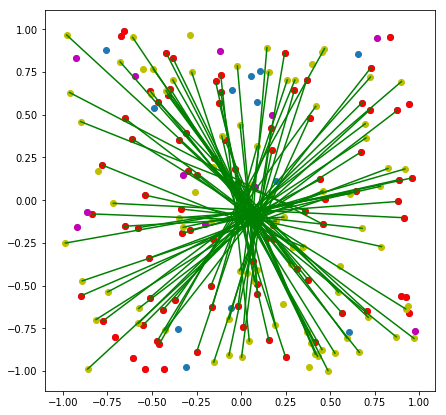

In [9]:
pxy = np.random.uniform(-1,1,(100,2))
dxy = np.random.uniform(-1,1,(100,2))
bxy = np.array([[0.0,0]])
dth = np.random.binomial(1, 0.8, dxy.shape[0])*10000
mask = np.random.binomial(1, 0.9, pxy.shape[0]).astype(bool)
thresh = 0.5

net = Net([5,30,1])

drones, points, fpnt = assign_targets(pxy, mask, dxy, bxy, dth, net, thresh)

plt.figure(figsize=(7,7))
plt.scatter(pxy[:,0], pxy[:,1])
plt.scatter(pxy[mask][:,0], pxy[mask][:,1], color='r')
plt.scatter(dxy[:,0], dxy[:,1], color='y')
plt.scatter(dxy[drones][points==-1,0], dxy[drones][points==-1,1], color='m')

for i,p in enumerate(points):
    if p!=-1:
        plt.plot([pxy[p][0], dxy[drones][i][0]],[pxy[p][1], dxy[drones][i][1]], 'g')

## High-level simulation of logistics

In [10]:
class Drone():
    def __init__(self, xy, base_xy, speed=13.88888, 
                 fly_discharge=0.00055555, msr_discharge=2.77778e-05, charge_time=600):
        self.speed = speed
        self.xy = xy.copy()
        self.base_xy = base_xy.copy()
        self.fly_discharge = fly_discharge
        self.msr_discharge = msr_discharge
        self.charge = 1.
        self.dt = 6.
        self.eps = 800 #85*4
        self.timeout = 0
        self.charge_steps = charge_time//self.dt
        self.landed = False
        self.update_death()
        self.c = 'y'
        
    def update_death(self):
        self.base_dist = np.sqrt(np.sum((self.xy-self.base_xy)**2))
        self.death_dist = self.charge/self.fly_discharge*self.speed
        self.returning = (self.death_dist <= self.base_dist + self.eps)
        
    def move_to(self, target, target_index):
        if self.timeout > 0:
            #self.timeout -= 1
            self.c = 'r'
            if self.timeout == 1:
                self.target_index = -3
                self.c = 'y'
            return
        
        self.charge -= self.fly_discharge*self.dt
        self.charge = max(self.charge, 0.)
        self.update_death()
        
        if self.returning:
            target = self.base_xy.copy()
            target_index = -1
            self.landed = False
        self.target = target
        self.target_index = target_index
        dist = np.sqrt(np.sum((self.xy-target)**2))

        if dist <= self.dt*self.speed:
            self.xy = target.copy()
            if target_index != -3:
                self.landed = True
            if target_index==-1:
                self.charge = 1.
                self.returning = False
                self.timeout = int(self.charge_steps)
                self.landed = False
            return
        if (self.landed or target_index==-2): #if landed or no tasks available
            return
        direct = target-self.xy
        direct = direct/np.sqrt(np.sum(direct**2))
        self.xy += direct*self.speed*self.dt
        
    def measure(self, i, N):
        if self.landed:
            self.charge -= (self.fly_discharge + self.msr_discharge)*self.dt
            self.charge = max(self.charge, 0)
            self.update_death()
            self.c = 'y' #['r','g','b','m'][i]
            if i==N-1:
                self.landed = False
                self.c = 'y'
            return self.target_index
        else:
            self.move_to(self.target, self.target_index)
            return -1

class Environment():
    def __init__(self, area_x=(4500,6500), area_y=(300,900), grid_x=41, grid_y=13,
                 base_xy=(5000.0,1000), num_drones=5, drones_xy=None, drone_speed=13.88888,
                 car_xy=(0.0,50), car_speed=1.38888, car_steps=[10,3,1], 
                 fly_discharge=0.00055555, msr_discharge=2.77778e-05, charge_time=600, num_chargers=2):
        self.i = 0
        self.dt = 6.
        self.grid_x = grid_x
        self.grid_x = grid_y
        self.area_x = area_x
        self.area_y = area_y
        x = np.zeros((grid_y,grid_x)) + np.linspace(area_x[0], area_x[1], grid_x)[None,:]
        y = np.zeros((grid_y,grid_x)) + np.linspace(area_y[0], area_y[1], grid_y)[:,None]
        self.points = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
        self.valid_mask = np.ones(self.points.shape[0], dtype=bool)
        
        self.car_xy = np.array(car_xy)[None]
        self.car_steps = np.cumsum([0] + car_steps)
        self.car_speed = car_speed
        self.new_points = self.get_drone_points()
        
        self.base_xy = np.array(base_xy)[None]
        if drones_xy is None:
            drones_xy = 10*np.random.normal(0,1,(num_drones,2)) + self.base_xy
        self.drones = [Drone(d[None], self.base_xy) for d in drones_xy]    
        self.num_chargers = num_chargers
        
        self.sending = False
        
        self.meandist = []
        
    def get_data(self):
        drones_xy = np.vstack([d.xy for d in self.drones])
        death = np.array([d.death_dist for d in self.drones])
        return [self.new_points, self.valid_mask, drones_xy, self.base_xy, death]
        
    def get_drone_points(self):
        j = self.i % self.car_steps[-1]
        xy = self.car_xy.copy()
        xy[0,0] += max(self.car_steps[1]-j, 0)*self.car_speed*self.dt
        return 2*(self.points - xy) + xy
    
    def recharge_drones(self):
        recharging = [d for d in self.drones if d.timeout > 0]
        for i in range(min(self.num_chargers, len(recharging))):
            recharging[i].timeout -= 1
#         if len(recharging)>=2:
#             recharging[1].timeout -= 1
#         if len(recharging)>=1:
#             recharging[0].timeout -= 1
    
    def step(self, assignment):
        self.recharge_drones()
        lo = self.car_steps[:-1]
        hi = self.car_steps[1:]
        j = self.i % self.car_steps[-1]
        if lo[0] <= j < hi[0]:
            self.car_xy[0, 0] += self.car_speed*self.dt
            if (self.car_xy[0, 0] >= 10000) or (self.car_xy[0, 0] < 0):
                self.car_speed *= -1
            self.sending = False
        elif lo[1] <= j < hi[1]:
            self.sending = True
        else:
            self.sending = True
            
        self.new_points = self.get_drone_points()
        
        mdst = np.mean(np.concatenate([[np.sqrt(np.sum((self.drones[i].xy-self.drones[j].xy)**2)) 
          for j in range(i)] 
         for i in range(len(self.drones))]))
        self.meandist.append(mdst)
            
        if self.sending:
            measured = np.array([d.measure((j-lo[1])%(hi[2]-lo[1]), hi[2]-lo[1]) for d in self.drones])
            measured = measured[measured >= 0]
            if measured.size>0:
                self.valid_mask[measured] = False
        else:
            for d,a in zip(self.drones, assignment):
                d.move_to(self.new_points[a][None], a)
            
        self.i += 1
        
    def visualize(self):
        plt.scatter(self.points[:,0], self.points[:,1], marker='.', label='interest points')
        c = 'g' if self.sending else 'r'
        pnt = self.new_points
        plt.scatter(pnt[:,0], pnt[:,1], color=c, marker='x', alpha=0.5, label='landing points')
        plt.scatter(pnt[~self.valid_mask,0], pnt[~self.valid_mask,1], color='m', alpha=0.5, label='measured')
        plt.scatter([self.car_xy[0,0]], [self.car_xy[0,1]], color='k', marker='D', label='source')
        plt.scatter([self.base_xy[0,0]], [self.base_xy[0,1]], color='k', marker='*', label='charger station')
        for i,d in enumerate(self.drones):
            c = ('k' if d.landed else 'y')
            if i==0:
                plt.scatter([d.xy[0,0]], [d.xy[0,1]], color=d.c, marker='>', alpha=(d.charge+1.0)/2, 
                            label='drones')
            else:
                plt.scatter([d.xy[0,0]], [d.xy[0,1]], color=d.c, marker='>', alpha=(d.charge+1.0)/2)
        plt.xlim(0,10000)
        plt.ylim(0,2000)
        plt.xlabel('X, m')
        plt.ylabel('Y, m')
        #plt.show()

In [31]:
env = Environment(grid_x=41,grid_y=13, num_drones=5, num_chargers=2)
for i in range(2500):
    _, _, points = assign_targets(*env.get_data(), None, 800)
    if points.size == 0:
        break
    env.step(points)
    env.visualize()
    plt.show()
    clear_output(True)

KeyboardInterrupt: 

## Control assignment by a random network

In [11]:
def run_environment(config_dict=dict(), net=None, params=None, steps=6000):
    env = Environment(**config_dict)
    scores = []
    if net is not None:
        assert params is not None
        net.set_params(params)
    for i in range(steps):
        _, _, points = assign_targets(*env.get_data(), net, 800)
        if points.size == 0:
            break
        env.step(points)
        scores.append(1-np.mean(env.valid_mask))
    return scores, env

#### Re-run this to get new result

In [9]:
config = dict()
net = SetNet([5,10,5])
params = net.get_params()
params.shape

(230,)

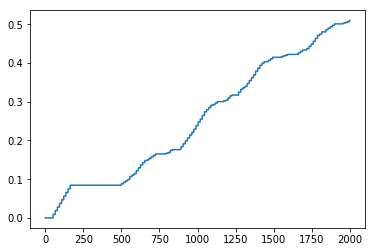

In [10]:
res, env = run_environment(config, net, params, steps=2000)
plt.plot(res)

In [235]:
env = Environment(num_drones=20)
for i in range(2500):
    _, _, points = assign_targets(*env.get_data(), net, 800)
    if points.size == 0:
        break
    env.step(points)
    env.visualize()
    plt.show()
    clear_output(True)

KeyboardInterrupt: 

## Adjust neural network with evolutionary algorithm

In [18]:
#mynet = SetNet([5,10,5])
#mynet = Net([5,10,1])
mynet = Lin(5)

myconfig = dict(car_speed=12)

def cost_func(parameters):
    net = mynet
    res, env = run_environment(myconfig, net, parameters, 2000)
    return -res[-1] #-np.mean(env.meandist)/1000

net = mynet
par = net.get_params()
minb = -3*np.ones_like(par)
maxb = 3*np.ones_like(par)

options = {
    'popsize': 10,
    'bounds': [minb, maxb], 
    'maxfevals': 199,
    'maxiter': 100000
}
options['seed'] = 1

es = cma.CMAEvolutionStrategy(np.zeros_like(par), 0.5, options)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [cost_func(x) for x in solutions])
    es.logger.add()
    es.disp()

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 5 (seed=1, Wed Dec 18 20:42:46 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -8.067542213883677e-01 1.0e+00 5.54e-01  5e-01  6e-01 0:19.8
    2     20 -8.330206378986866e-01 1.6e+00 5.32e-01  5e-01  6e-01 0:34.4
    3     30 -8.048780487804879e-01 1.9e+00 6.30e-01  5e-01  8e-01 0:48.6
    4     40 -8.480300187617260e-01 2.0e+00 7.06e-01  6e-01  9e-01 1:02.9
    5     50 -8.499061913696060e-01 2.1e+00 6.65e-01  5e-01  8e-01 1:18.2
    6     60 -8.461538461538461e-01 2.0e+00 7.47e-01  5e-01  9e-01 1:33.9
    7     70 -8.461538461538461e-01 2.2e+00 8.35e-01  5e-01  1e+00 1:50.7
    8     80 -8.461538461538461e-01 2.6e+00 8.45e-01  5e-01  1e+00 2:08.6
    9     90 -8.480300187617260e-01 2.5e+00 7.93e-01  5e-01  1e+00 2:23.8
   10    100 -8.424015009380863e-01 2.6e+00 8.50e-01  4e-01  1e+00 2:40.1
   11    110 -8.461538461538461e-01 2.9e+00 9.01e-01  5e-01  1e+00 2:56.5
   12    120 -8.499061913696

KeyboardInterrupt: 

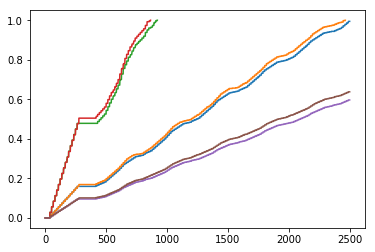

In [21]:
def cost_func(config, net, parameters):
    res, env = run_environment(config, net, parameters, 2500)
    return res

config = dict(car_speed=12)
plt.plot(cost_func(config, None, None))
plt.plot(cost_func(config, net, es.best.x))

config = dict(car_speed=12, num_drones=15, num_chargers=5)
plt.plot(cost_func(config, None, None))
plt.plot(cost_func(config, net, es.best.x))

config = dict(car_speed=12, num_drones=3, num_chargers=1)
plt.plot(cost_func(config, None, None))
plt.plot(cost_func(config, net, es.best.x))

In [20]:
net.set_params(es.best.x)
env = Environment(**myconfig)
for i in range(1000):
    _, _, points = assign_targets(*env.get_data(), net, 800)
    if points.size == 0:
        break
    env.step(points)
    env.visualize()
    plt.show()
    clear_output(True)

KeyboardInterrupt: 

In [61]:
env.area_x

(4500, 6500)

In [126]:
results = []
for nd in range(1,20):
    print(nd)
    for nc in range(1,nd+1):
        res, _ = run_environment({'num_drones':nd, 'num_chargers':nc}, steps=15000)
        results.append([nd, nc, np.argmax(res)])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [128]:
results = np.array(results)

In [151]:
table = np.zeros((19,19))
for nd, nc, v in results:
    table[nc-1,nd-1] = v
for nc in range(1,20):
    for nd in range(1,20):
        if nc > nd:
            table[nc-1,nd-1] = table[nd-1,nd-1]

<IPython.core.display.Javascript object>


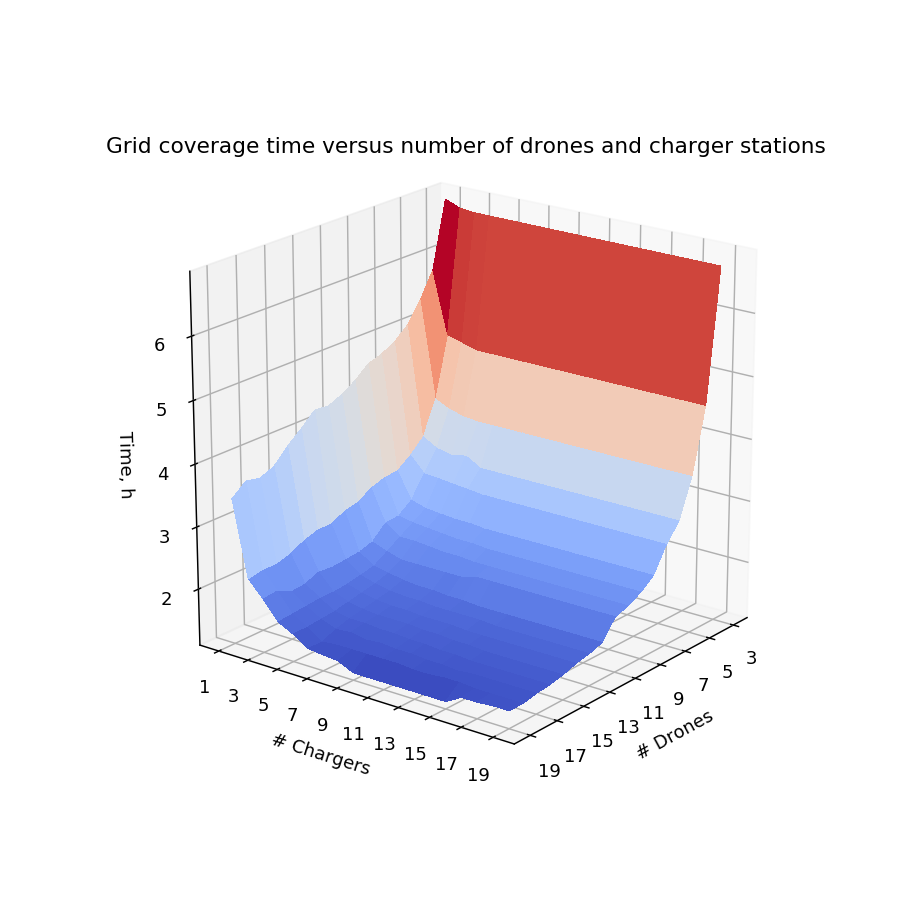

Text(0.5, 0.92, 'Grid coverage time versus number of drones and charger stations')

In [159]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
%matplotlib notebook


fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

X = np.arange(3,20)
Y = np.arange(1,20)
Xg, Yg = np.meshgrid(X, Y)

surf = ax.plot_surface(Xg, Yg, table[:,2:]*6/3600, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('# Drones')
ax.set_ylabel('# Chargers')
ax.set_zlabel('Time, h')
ax.set_xticks(X[::2])
ax.set_yticks(Y[::2])
ax.set_title('Grid coverage time versus number of drones and charger stations')

In [162]:
#plt.savefig('pic/drone_charger.png')

In [290]:
%matplotlib inline

net = Net([5,15,1])

net.set_params(np.load('border_strategy.npy'))


env = Environment()
for i in range(1400):
    _, _, points = assign_targets(*env.get_data(), net, 800)
    if points.size == 0:
        break
    env.step(points)
plt.figure(figsize=(7,5))
env.visualize()
plt.legend()
plt.title('Border strategy of a neural net')
plt.savefig('./pic/border.png')
plt.show()

ValueError: cannot reshape array of size 66 into shape (5,15)

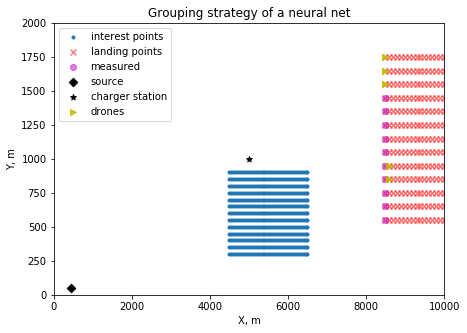

In [246]:
net.set_params(np.load('block_strategy.npy'))

env = Environment()
for i in range(75):
    _, _, points = assign_targets(*env.get_data(), net, 800)
    if points.size == 0:
        break
    env.step(points)
plt.figure(figsize=(7,5))
env.visualize()
plt.legend()
plt.title('Grouping strategy of a neural net')
#plt.savefig('./pic/group.pdf')
plt.show()

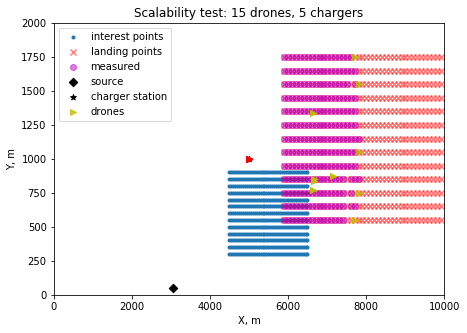

In [253]:
env = Environment(num_drones=15, num_chargers=5)
for i in range(510):
    _, _, points = assign_targets(*env.get_data(), None, 800)
    if points.size == 0:
        break
    env.step(points)
plt.figure(figsize=(7,5))
env.visualize()
plt.legend()
plt.title('Scalability test: 15 drones, 5 chargers')
#plt.savefig('./pic/scale.pdf')
plt.show()

In [255]:
import imageio

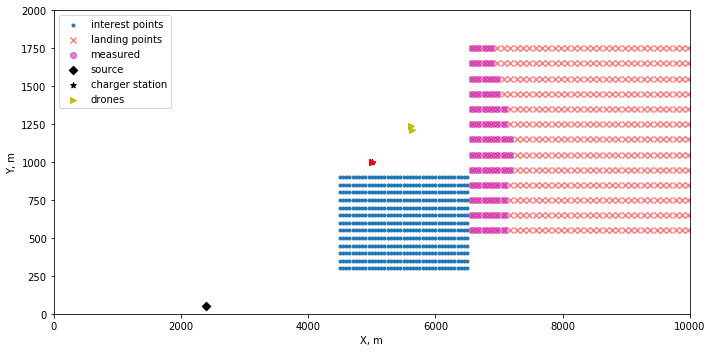

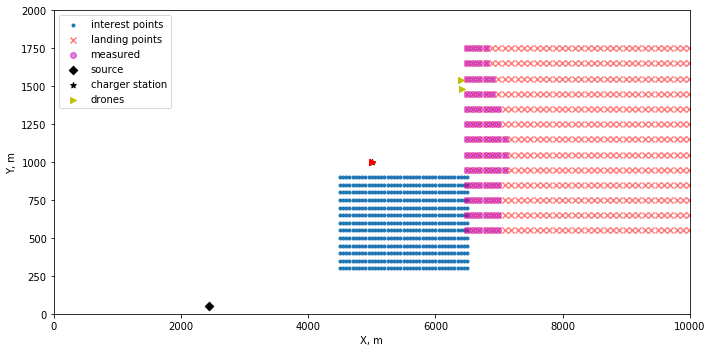

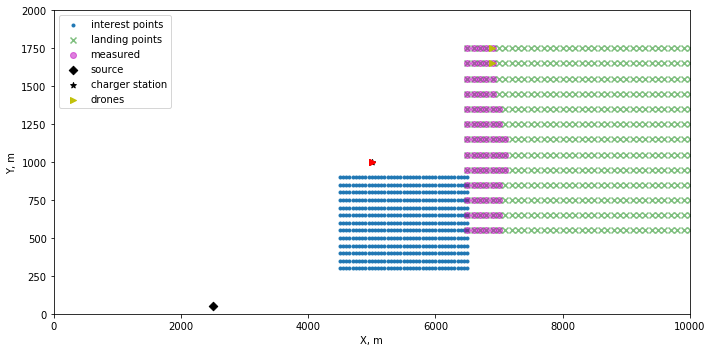

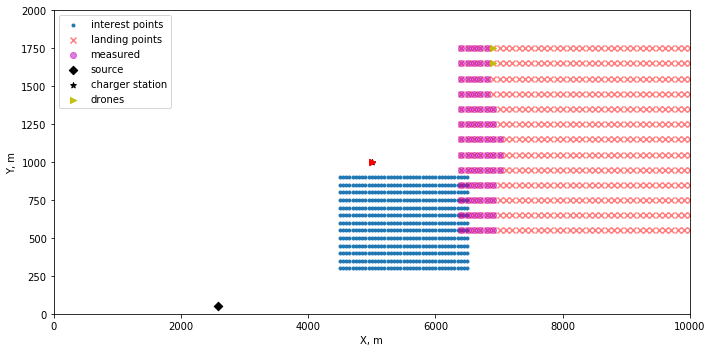

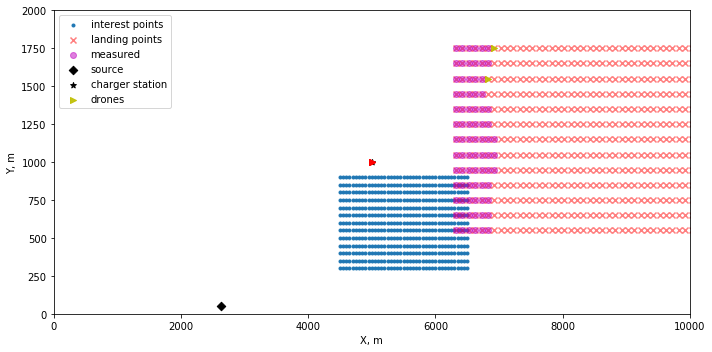

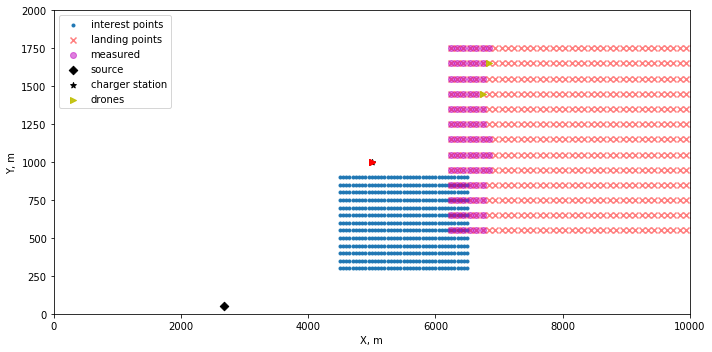

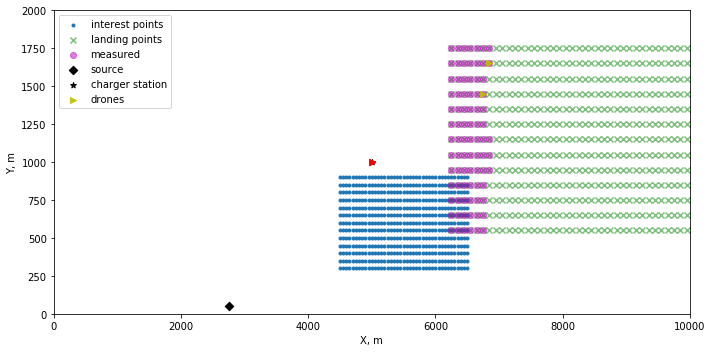

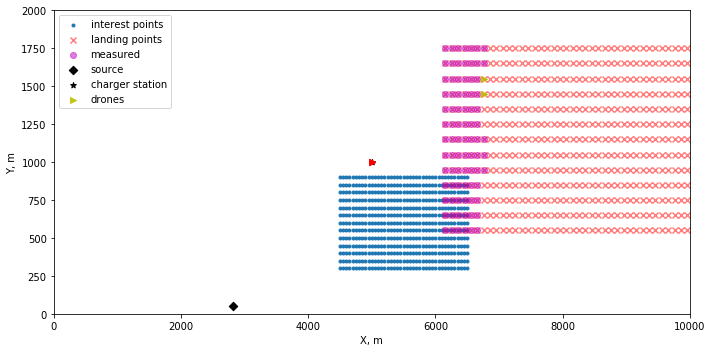

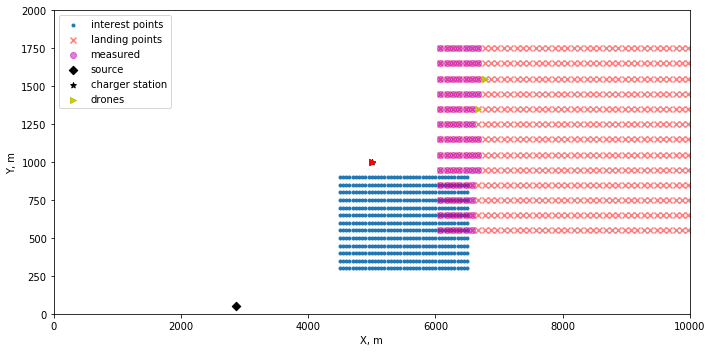

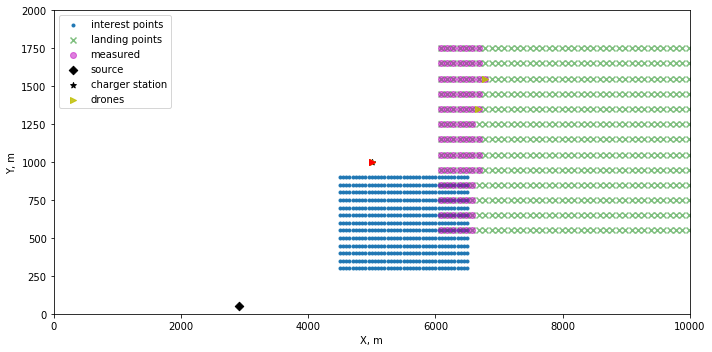

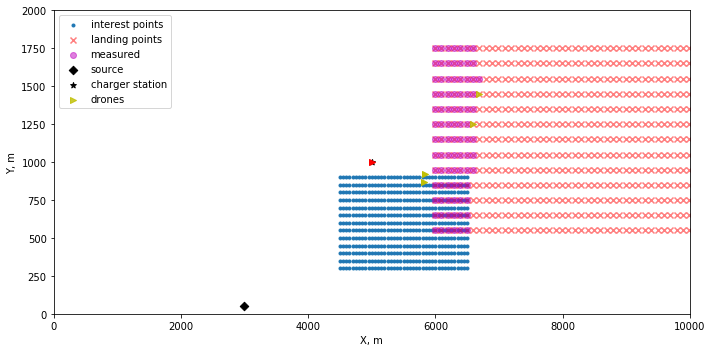

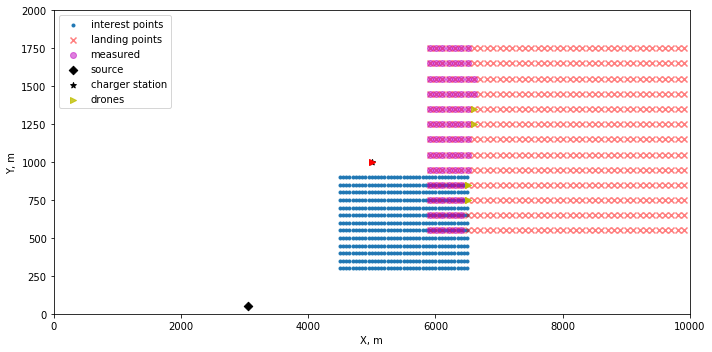

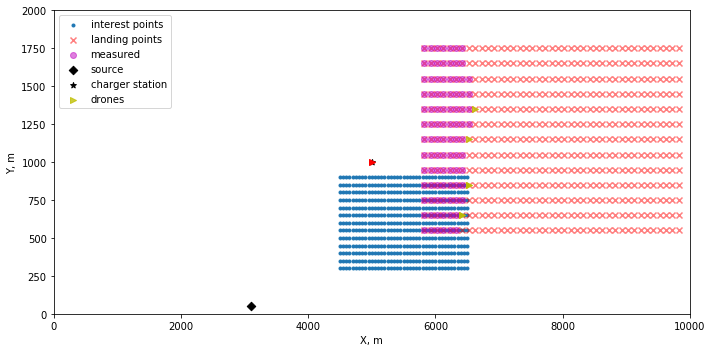

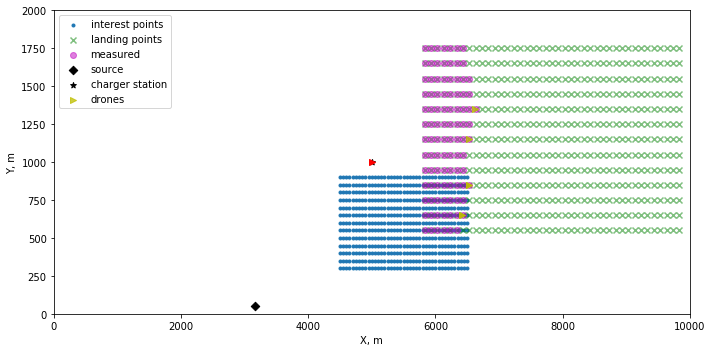

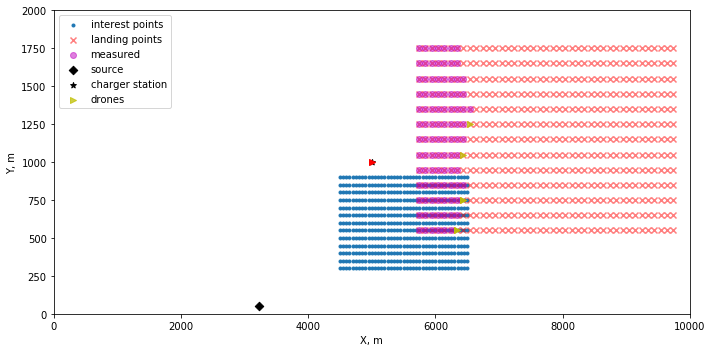

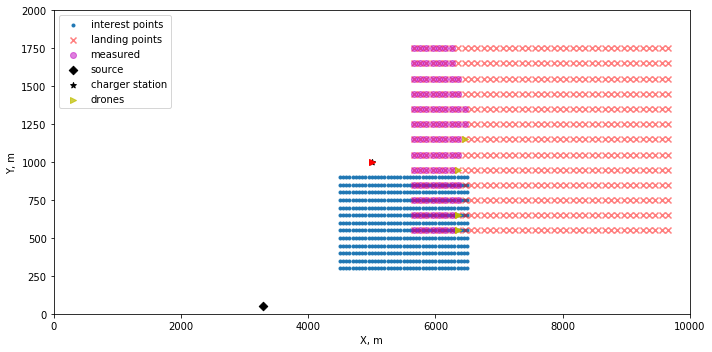

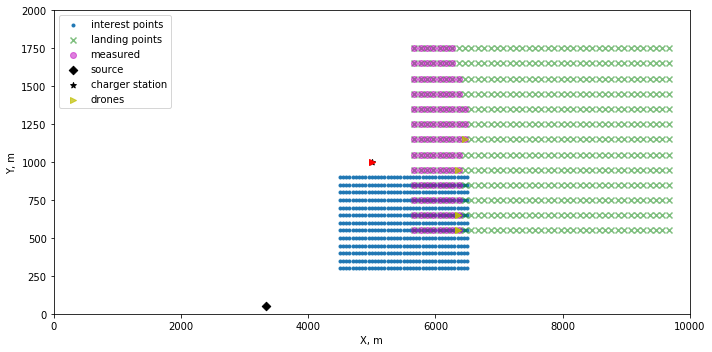

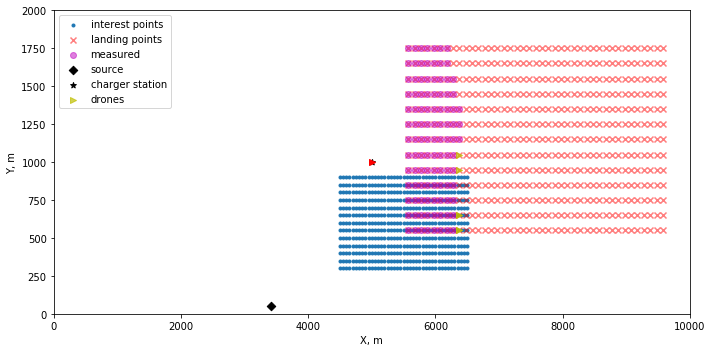

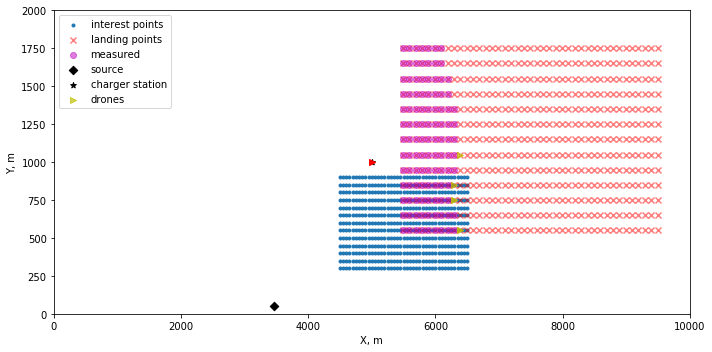

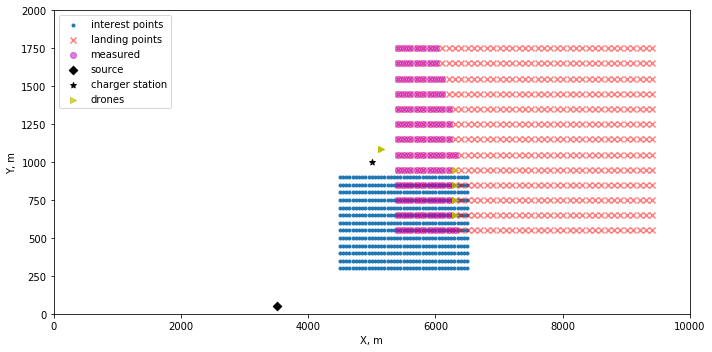

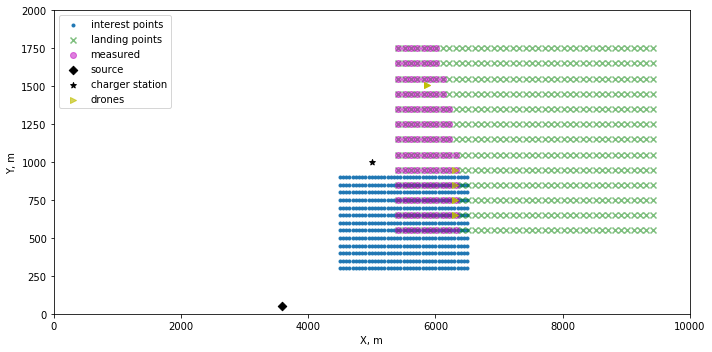

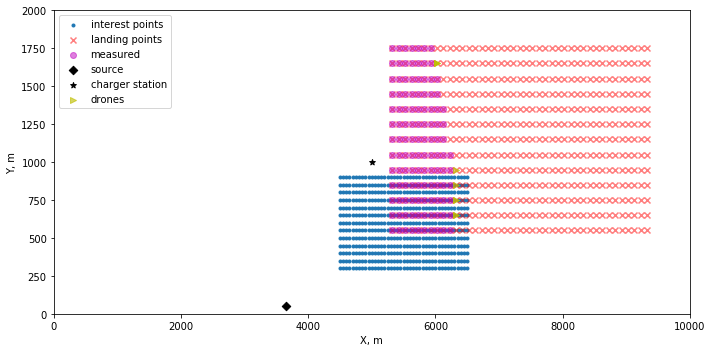

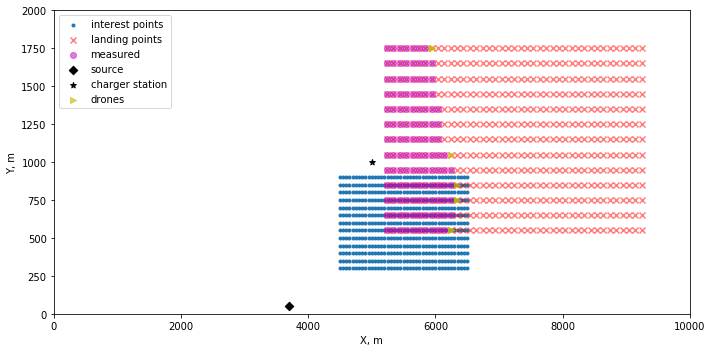

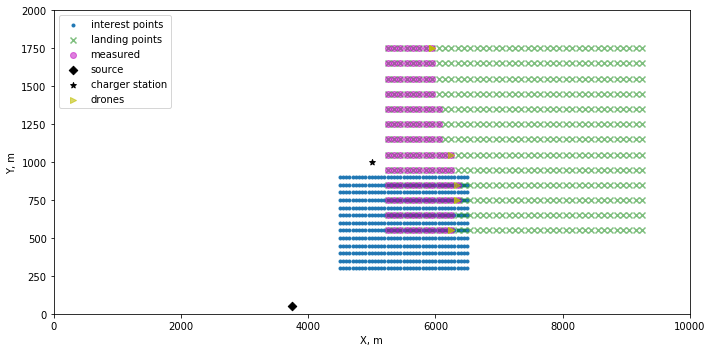

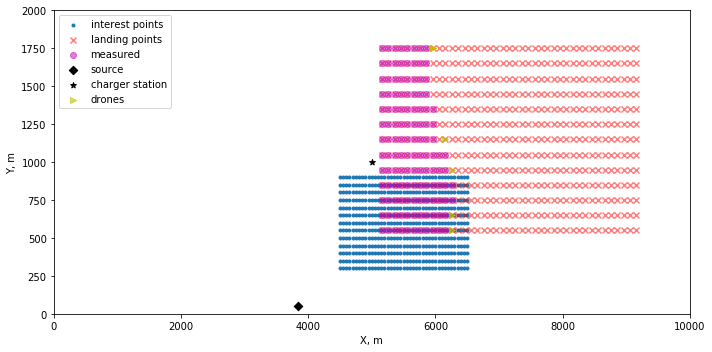

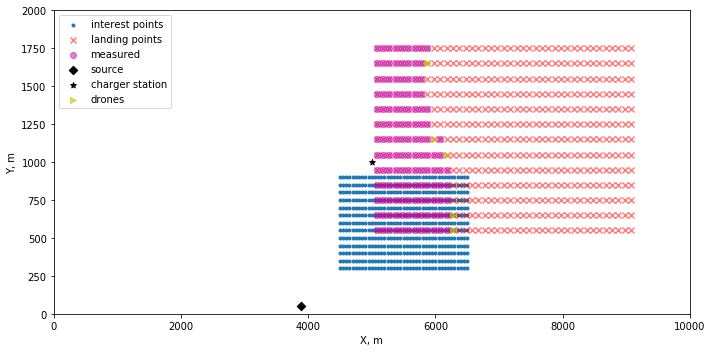

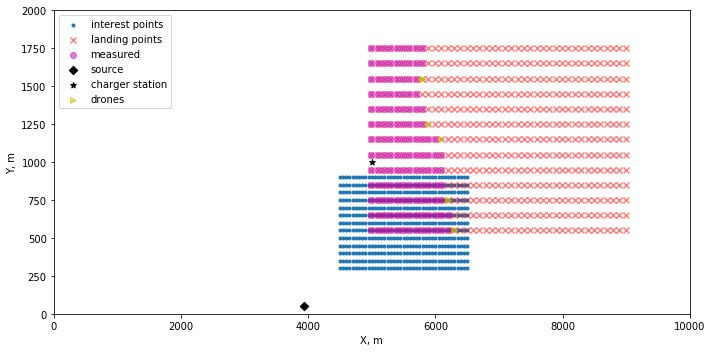

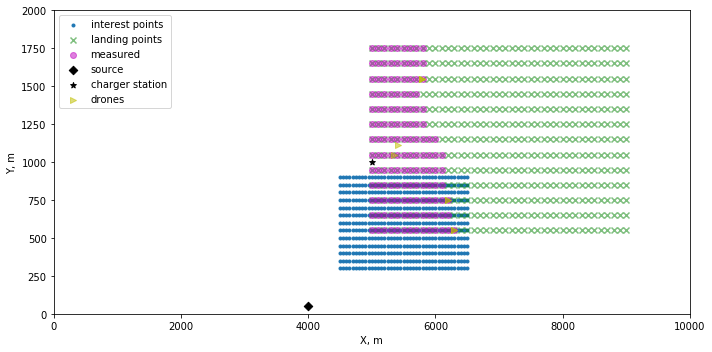

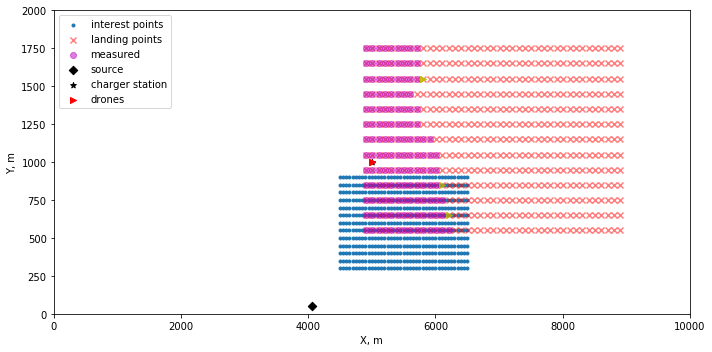

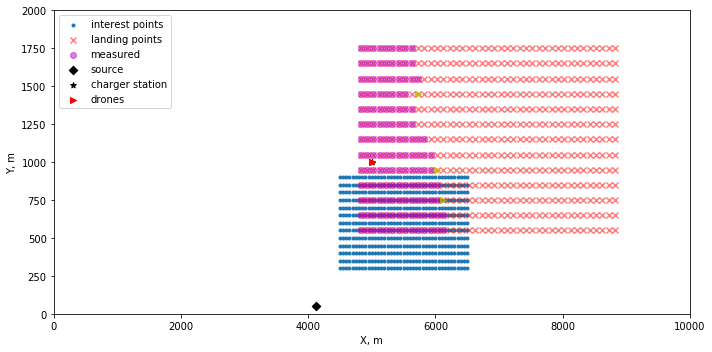

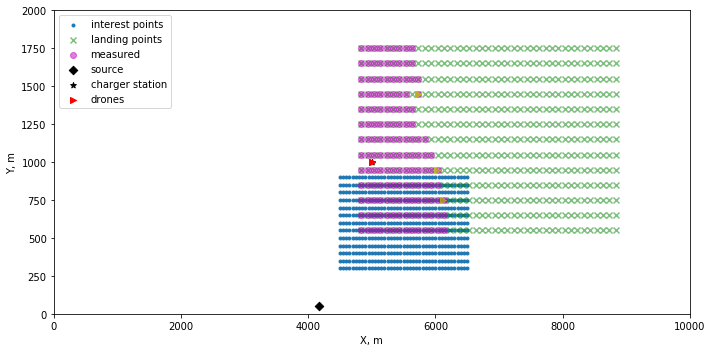

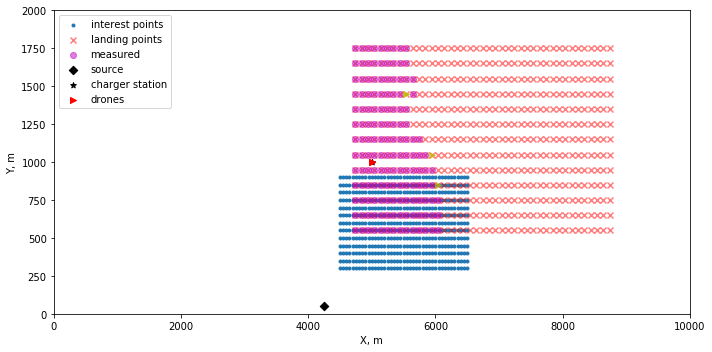

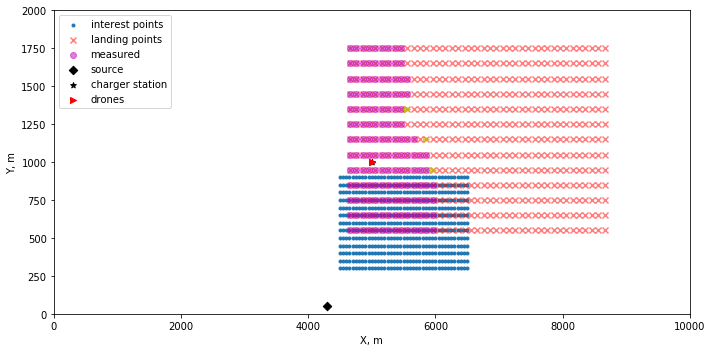

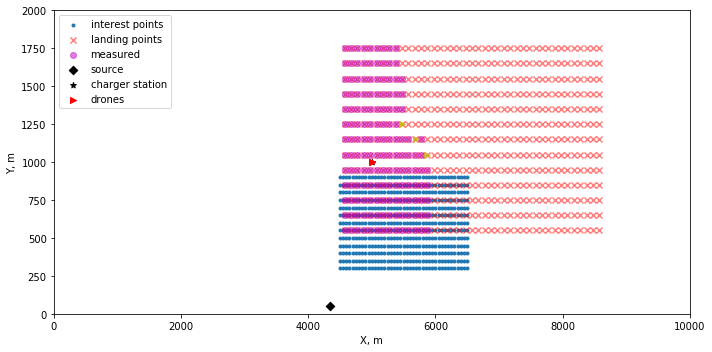

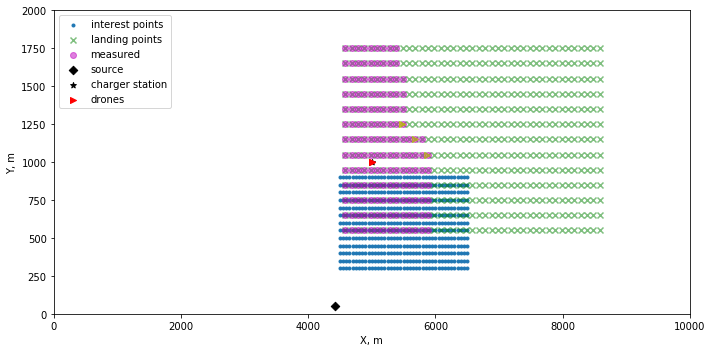

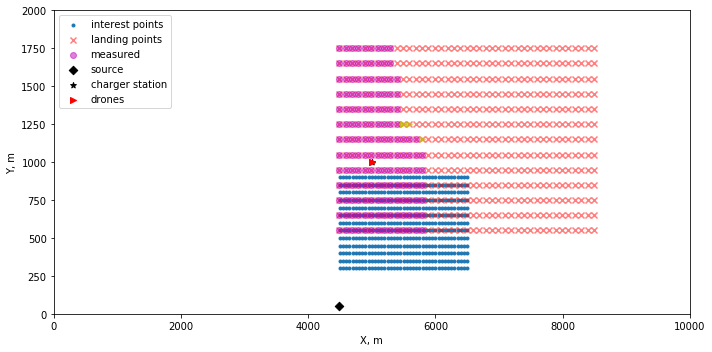

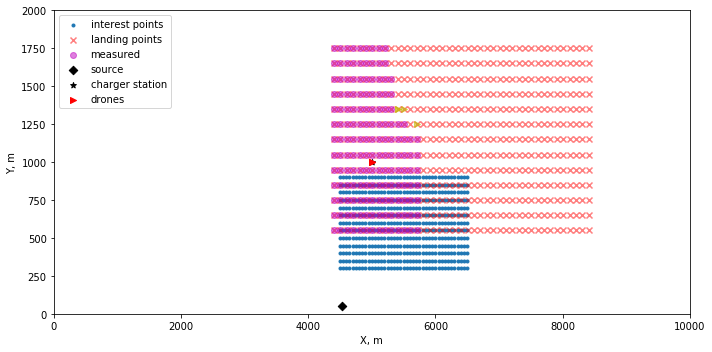

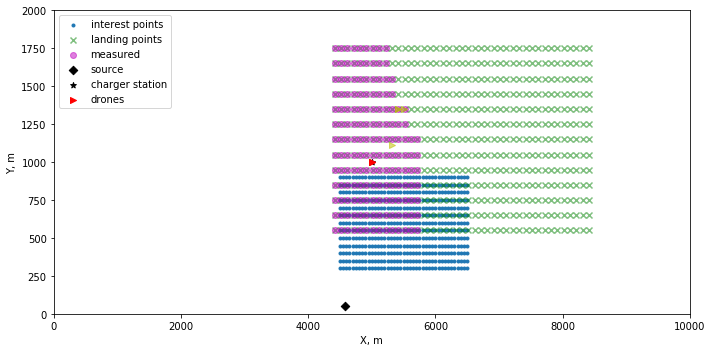

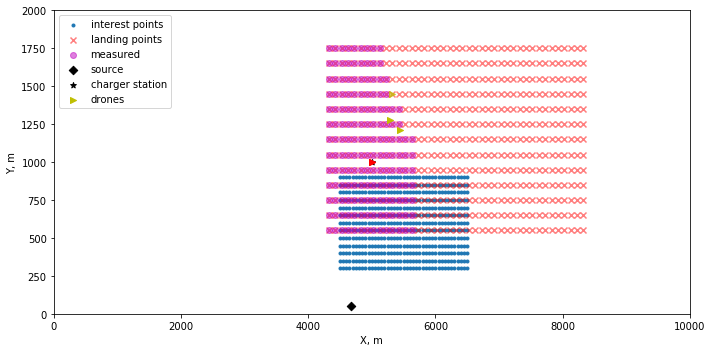

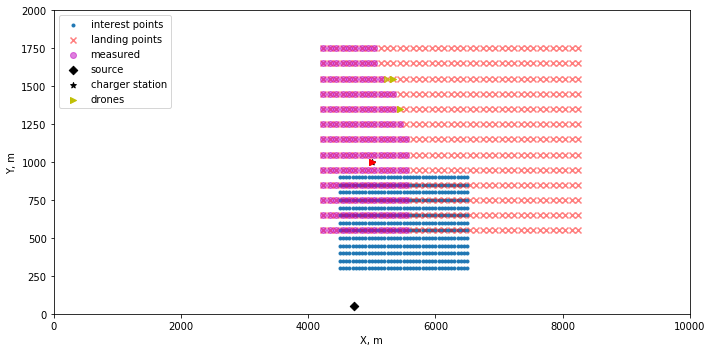

In [282]:
images = []

env = Environment(num_drones=5, num_chargers=2)
for i in range(390):
    _, _, points = assign_targets(*env.get_data(), None, 800)
    if points.size == 0:
        break
    env.step(points)
for k in range(40):
    for i in range(10):
        _, _, points = assign_targets(*env.get_data(), None, 800)
        if points.size == 0:
            break
        env.step(points)
    fig, ax = plt.subplots(figsize=(10,5))
    env.visualize()
    plt.legend()
    plt.tight_layout()
        
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
    
imageio.mimsave('./pic/demo.gif', images, fps=3)